<a href="https://colab.research.google.com/github/arkalim/Tensorflow/blob/master/Mnist_tf_slim_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN on MNIST dataset using TF
## Importing necessary libraries and defining model parameters

In [0]:
# Loading the required packages
import tensorflow as tf 
import datetime, os
import matplotlib.pyplot as plt 
import tensorflow.contrib.layers as layers
from sklearn.preprocessing import MinMaxScaler
slim = tf.contrib.slim

# Empty lists for storing the loss and accuracy history
train_loss = []
train_acc = []
validation_acc = []
validation_loss = []

# Parameters
learning_rate = 0.001
training_iters = 100
batch_size = 1024
display_step = 5

# Data Preprocessing

In [0]:
# Now we load the mnist dataset
# each handwritten digit is of the size 28*28 i.e. 784 pixels grayscale image
from tensorflow.examples.tutorials.mnist import input_data
from sklearn.preprocessing import MinMaxScaler

# we use one hot encoding for labels
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

# 55000 examples with grayscale image of 784 pixels (images are already flattened)
print(mnist.train.images.shape)
# the labels are one hot encoded
print(mnist.train.labels.shape)
# 10000 test examples
print(mnist.test.images.shape)
print(mnist.test.labels.shape)

# Fetch the validation data and normalize it
# Training data will be normalized after fetching the batch of training data
X_valid = mnist.test.images
X_valid = MinMaxScaler(feature_range=(0, 1)).fit_transform(X_valid)
Y_valid = mnist.test.labels

# Network Parameters
n_input = 784 # MNIST data input (img shape: 28*28)
n_classes = 10 # MNIST total classes (0-9 digits)
dropout = 0.85 # Dropout, probability to keep units

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py fr

# Creating Computational Graph

In [0]:
def model(images):
    
    images = tf.reshape(images, shape=[-1, 28, 28, 1])
    
    net = slim.conv2d(images, 32, [5,5], scope='conv1')
    net = slim.max_pool2d(net, [2,2], scope='pool1')
    
    net = slim.conv2d(net, 64, [5,5], scope='conv2')
    net = slim.max_pool2d(net, [2,2], scope='pool2')
    
    net = slim.flatten(net, scope='flatten3')
    net = slim.fully_connected(net, 512, scope='fc4')
    net = slim.fully_connected(net, 10, activation_fn=None, scope='fc5')
    return net
   
with tf.name_scope("Placeholders"):    
    # Defining the features and labels placeholders
    X = tf.placeholder(tf.float32 ,shape = [None , 784] , name='X')
    Y = tf.placeholder(tf.float32,shape = [None , 10], name='Y')
    keep_prob = tf.placeholder(tf.float32)
   
 
# Create the CNN model
# keep_prob is the probability to keep a node during training
pred = model(X)

with tf.name_scope("Loss"):    
    # Defining the loss function
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=Y))
    tf.summary.scalar("Loss",loss)

with tf.name_scope("Optimizer"):
    # Defining the optimization function
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

with tf.name_scope("Accuracy"):    
    # The prediction is correct when Y equals pred
    correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(Y, 1))

    # Defining the accuracy
    # Type casting the prediction to float value and averaging over the entire set
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    tf.summary.scalar("Accuracy",accuracy)

with tf.name_scope("Initializer"):    
    # Defining the variable initialisation function
    init = tf.global_variables_initializer()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



# Training the model

In [0]:
!pip install -q tf-nightly-2.0-preview
# Load the TensorBoard notebook extension
%load_ext tensorboard

with tf.Session() as sess:
    
    # Initialise the variables
    sess.run(init)
    
    # Clear any prior data in logs
    !rm -rf 'logs'
    
    # create a train summary writer
    train_writer = tf.summary.FileWriter('logs/train' , sess.graph)
    
    # create a valid summary writer
    valid_writer = tf.summary.FileWriter('logs/valid' , sess.graph)
    
    # merge all the summaries
    merged = tf.summary.merge_all()

    # Load Tensorboard at the two directories
    %tensorboard --logdir Train:'logs/train',Valid:'logs/valid'

    for step in range(training_iters):
        
        # Fetching the next batch of data
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        
        # Normalising the data
        batch_x = MinMaxScaler(feature_range=(0, 1)).fit_transform(batch_x)
        
        # Train our model on the batch of data
        sess.run(optimizer, feed_dict={X : batch_x , Y : batch_y , keep_prob : dropout})
        
        # Displaying the loss and accuracy
        if step % display_step == 0:
            
            # Evaluate the train loss and accuracy with no dropout
            summary, loss_train, acc_train = sess.run([merged, loss , accuracy], feed_dict={X: batch_x,Y: batch_y,keep_prob: 1.0})
            
            # write the train summary for the current epoch
            train_writer.add_summary(summary, step)
            # flush the fliewriter to send the values to the file
            train_writer.flush()
    
            # Evaluate the test accuracy with no dropout
            summary, loss_valid, acc_valid = sess.run([merged, loss , accuracy], feed_dict={X: X_valid, Y: Y_valid,keep_prob: 1.0})
            
            # write the validation summary for the current epoch
            valid_writer.add_summary(summary, step)
            
            # flush the fliewriter to send the values to the file
            valid_writer.flush()
            
            print ("Epoch " + str(step) + ", Train Loss= " + "{:.2f}".format(loss_train) + ", Training Accuracy= " + "{:.2f}".format(acc_train) + ", Validation Loss= " + "{:.2f}".format(loss_valid)+ ", Validation Accuracy:" + "{:.2f}".format(acc_valid))
    
            # Append the data for plotting
            train_loss.append(loss_train)
            train_acc.append(acc_train)
            validation_acc.append(acc_valid)
            validation_loss.append(loss_valid)  

     |████████████████████████████████| 87.4MB 1.4MB/s 
     |████████████████████████████████| 61kB 20.7MB/s 
     |████████████████████████████████| 3.1MB 45.1MB/s 
     |████████████████████████████████| 440kB 44.0MB/s 
ERROR: thinc 6.12.1 has requirement wrapt<1.11.0,>=1.10.0, but you'll have wrapt 1.11.1 which is incompatible.


Epoch 0, Train Loss= 2.14, Training Accuracy= 0.43, Validation Loss= 2.15, Validation Accuracy:0.41
Epoch 5, Train Loss= 0.91, Training Accuracy= 0.78, Validation Loss= 0.90, Validation Accuracy:0.78
Epoch 10, Train Loss= 0.46, Training Accuracy= 0.85, Validation Loss= 0.45, Validation Accuracy:0.87
Epoch 15, Train Loss= 0.43, Training Accuracy= 0.87, Validation Loss= 0.41, Validation Accuracy:0.88
Epoch 20, Train Loss= 0.35, Training Accuracy= 0.91, Validation Loss= 0.32, Validation Accuracy:0.91
Epoch 25, Train Loss= 0.30, Training Accuracy= 0.92, Validation Loss= 0.25, Validation Accuracy:0.93
Epoch 30, Train Loss= 0.26, Training Accuracy= 0.93, Validation Loss= 0.23, Validation Accuracy:0.94
Epoch 35, Train Loss= 0.23, Training Accuracy= 0.94, Validation Loss= 0.20, Validation Accuracy:0.94
Epoch 40, Train Loss= 0.18, Training Accuracy= 0.95, Validation Loss= 0.17, Validation Accuracy:0.95
Epoch 45, Train Loss= 0.16, Training Accuracy= 0.95, Validation Loss= 0.15, Validation Accura

# Plotting the results

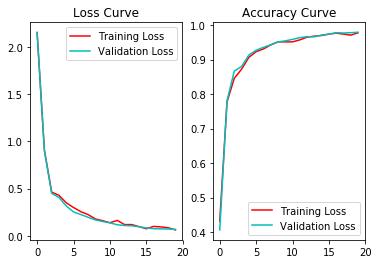

In [0]:
plt.subplot(1,2,1)
plt.title("Loss Curve")
plt.plot(train_loss, 'r', label='Training Loss')
plt.plot(validation_loss,  'c', label='Validation Loss')
plt.legend()

plt.subplot(1,2,2)
plt.title("Accuracy Curve")
plt.plot(train_acc, 'r', label='Training Loss')
plt.plot(validation_acc, 'c', label='Validation Loss')
plt.legend()

plt.show()       